## $$ \textrm{Moving Beyond Linearity} $$

## 1. 기본 설정 정리

- ISLP 인스톨 및 기본 패키지 불러오기

In [3]:
!pip install ISLP
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize, poly, ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_c

- 불러오는 모형들은 GAM 그리고 비선형 적합을 위한 스팔라인과 같은 것들임




In [5]:
from pygam import (s as s_gam, l as l_gam, f as f_gam, LinearGAM, LogisticGAM)
from ISLP.transforms import (BSpline, NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam, degrees_of_freedom, plot as plot_gam, anova as anova_gam)

# 2. Wage 데이터 분석



In [6]:
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']

- 4차 다항식 $(x , x^2, x^3, x^4)$으로 분석


In [7]:
# 4차 다항식의 변수확장을 위한 전 처리
# ------------------------------------
poly_age = MS([poly('age', degree=4)]).fit(Wage)
M = sm.OLS(y, poly_age.transform(Wage)).fit()
summarize(M)

age_grid = np.linspace(age.min(), age.max(),100)
age_df = pd.DataFrame({'age': age_grid})

In [8]:
# 4차 다항식의 적합 결과를 그리기 위한 함수를 만들고 적합해서 결과를 확인함
# -------------------------------------------------------------------------
def plot_wage_fit(age_df, basis, title):
  X = basis.transform(Wage)
  Xnew = basis.transform(age_df)
  M = sm.OLS(y, X).fit()
  preds = M.get_prediction(Xnew)
  bands = preds.conf_int(alpha=0.05)
  fig , ax = subplots(figsize=(8,8))
  ax.scatter(age, y, facecolor='gray', alpha=0.5)
  for val, ls in zip([preds.predicted_mean, bands[:,0], bands[:,1]],['b','r--','r--']):
    ax.plot(age_df.values , val , ls, linewidth=3)
    ax.set_title(title , fontsize =20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20);
  return ax

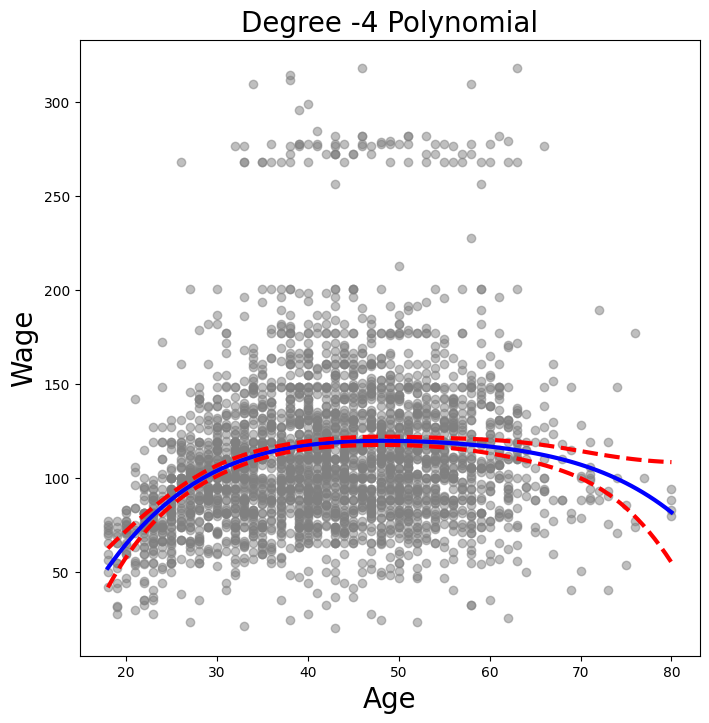

In [9]:
# 가운데 선은 평균, 위 아래 선들은 95% 수준의 (평균에 대한) 신뢰구간들임
# ---------------------------------------------------------------------
plot_wage_fit(age_df, poly_age, 'Degree -4 Polynomial');

- 다항식의 차수를 1차에서 6차까지 조쟁해 면서

In [10]:
models = [MS([poly('age', degree=d)])
  for d in range(1, 6)]
Xs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit()
  for X_ in Xs])
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [ ]:
models = [MS(['education', poly('age', degree=d)])
for d in range(1, 4)]
XEs = [model.fit_transform(Wage)
for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in XEs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2997.0,3.902335e+06,0.0,NaN,NaN,NaN
1,2996.0,3.759472e+06,1.0,142862.701185,113.991883,3.838075e-26
2,2995.0,3.753546e+06,1.0,5926.207070,4.728593,2.974318e-02


In [ ]:
X = poly_age.transform(Wage)
high_earn = Wage['high_earn'] = y > 250 # shorthand
glm = sm.GLM(y > 250, X, family=sm.families.Binomial())
B = glm.fit()
summarize(B)
# logistic regression

,coef,std err,z,P>|z|
intercept,-4.3012,0.345,-12.457,0.000
"poly(age, degree=4)[0]",71.9642,26.133,2.754,0.006
"poly(age, degree=4)[1]",-85.7729,35.929,-2.387,0.017
"poly(age, degree=4)[2]",34.1626,19.697,1.734,0.083
"poly(age, degree=4)[3]",-47.4008,24.105,-1.966,0.049


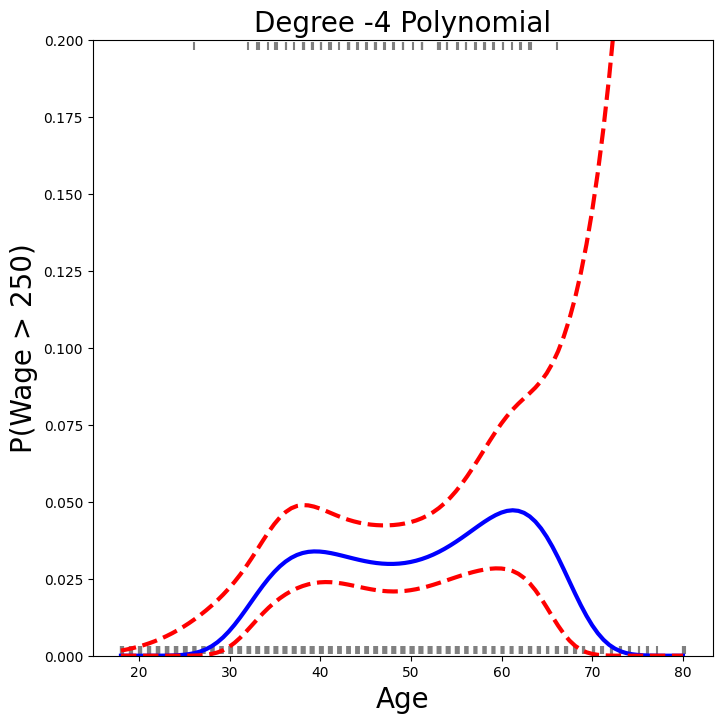

In [ ]:
newX = poly_age.transform(age_df)
preds = B.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

fig , ax = subplots(figsize=(8,8))
rng = np.random.default_rng(0)
ax.scatter(age + 0.2 * rng.uniform(size=y.shape[0]), np.where(high_earn , 0.198, 0.002),
fc='gray', marker='|')
for val , ls in zip([preds.predicted_mean, bands[:,0], bands[:,1]], ['b','r--','r--']):
  ax.plot(age_df.values , val , ls, linewidth=3)
ax.set_title('Degree -4 Polynomial', fontsize=20)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylim ([0,0.2])
ax.set_ylabel('P(Wage > 250)', fontsize=20);

In [ ]:
cut_age = pd.qcut(age , 4)
summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


In [ ]:
bs_ = BSpline(internal_knots=[25,40,60], intercept=True).fit(age)
bs_age = bs_.transform(age)
bs_age.shape

bs_age = MS([bs('age', internal_knots=[25,40,60])])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

bs_age = MS([bs('age', internal_knots=[25,40,60], name='bs(age)')])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
bs(age)[0],3.9805,12.538,0.317,0.751
bs(age)[1],44.6310,9.626,4.636,0.000
bs(age)[2],62.8388,10.755,5.843,0.000
bs(age)[3],55.9908,10.706,5.230,0.000
bs(age)[4],50.6881,14.402,3.520,0.000
bs(age)[5],16.6061,19.126,0.868,0.385


In [ ]:
BSpline(df=6).fit(age).internal_knots_

array([33.75, 42.  , 51.  ])

In [ ]:
bs_age0 = MS([bs('age', df=3, degree=0)]).fit(Wage)
Xbs0 = bs_age0.transform(Wage)
summarize(sm.OLS(y, Xbs0).fit())

,coef,std err,t,P>|t|
intercept,94.1584,1.478,63.687,0.0
"bs(age, df=3, degree=0)[0]",22.3490,2.152,10.388,0.0
"bs(age, df=3, degree=0)[1]",24.8076,2.044,12.137,0.0
"bs(age, df=3, degree=0)[2]",22.7814,2.087,10.917,0.0


          age
0   18.000000
1   18.626263
2   19.252525
3   19.878788
4   20.505051
..        ...
95  77.494949
96  78.121212
97  78.747475
98  79.373737
99  80.000000

[100 rows x 1 columns]


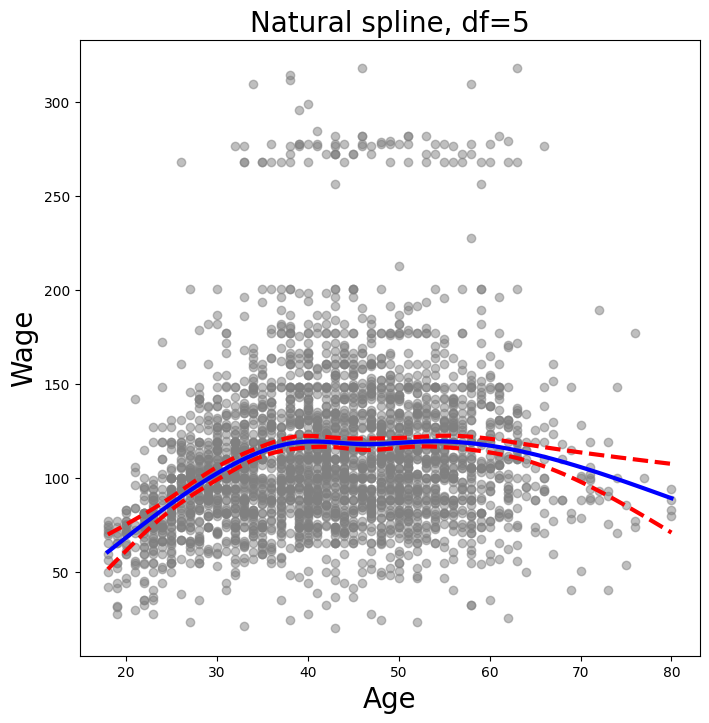

In [ ]:
ns_age = MS([ns('age', df=5)]).fit(Wage)
M_ns = sm.OLS(y, ns_age.transform(Wage)).fit()
summarize(M_ns)
print(age_df)
plot_wage_fit(age_df, ns_age, 'Natural spline, df=5');

In [ ]:
X_age = np.asarray(age).reshape((-1,1))
gam = LinearGAM(s_gam(0, lam=0.6))
gam.fit(X_age , y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

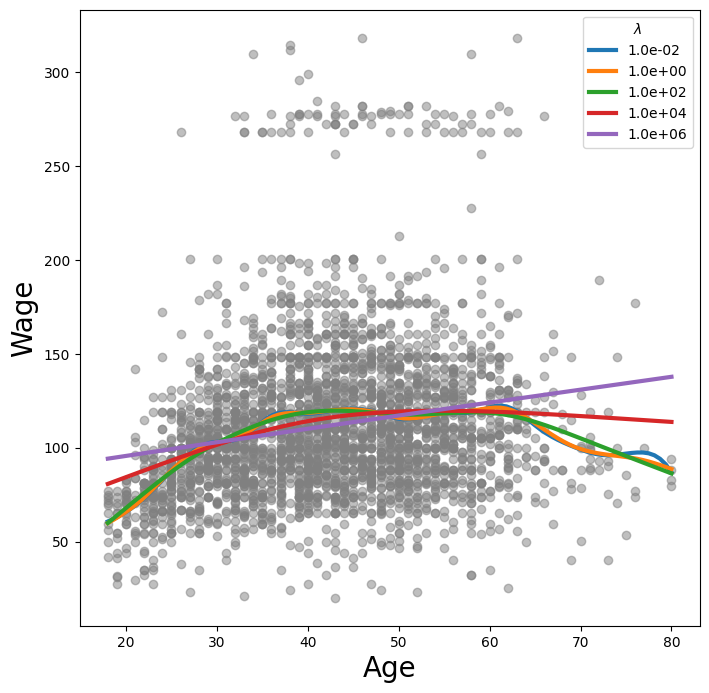

In [ ]:
fig , ax = subplots(figsize=(8,8))
ax.scatter(age , y, facecolor='gray', alpha=0.5)
for lam in np.logspace(-2, 6, 5):
  gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age , y)
  ax.plot(age_grid, gam.predict(age_grid), label='{:.1e}'.format(lam), linewidth=3)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='$\lambda$');

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


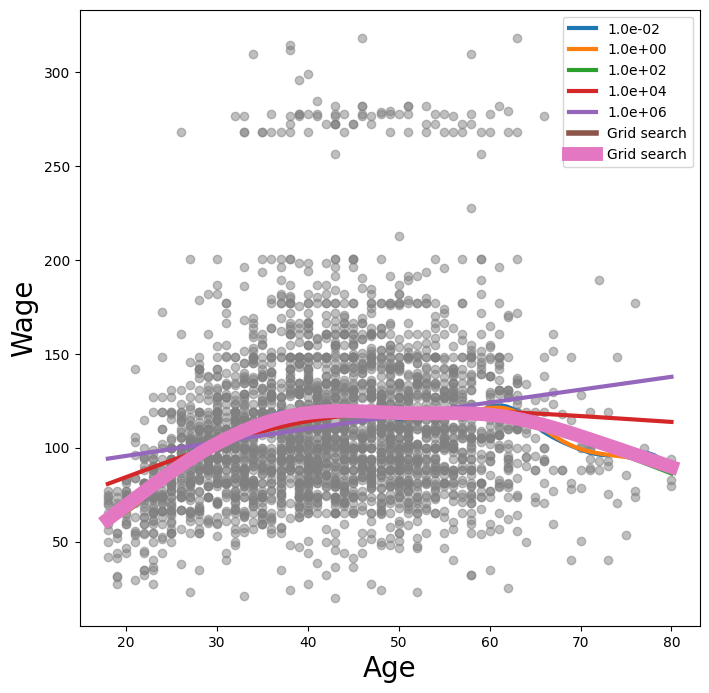

In [ ]:
gam_opt = gam.gridsearch(X_age , y)
ax.plot(age_grid, gam_opt.predict(age_grid), label='Grid search', linewidth=10)
ax.legend()
fig